In [5]:
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, accuracy_score, root_mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Question 1:
Dataset used: Taiwanese Bankruptcy Prediction

URL: https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction

In [34]:
# Checking the number of columns and looking at the column headers.
with open('data.csv') as f:
    fields = f.readline().split(',')
print(len(fields),'\n', fields[:5])
# Reading in the data
data = np.loadtxt('data.csv',delimiter=',', skiprows=1)
print(data.shape)
x = data[:,1:] # First column contains the labels
y = data[:,0] # Labels of the data
print(x.shape, y.shape)

96 
 ['Bankrupt?', ' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin']
(6819, 96)
(6819, 95) (6819,)


In [36]:
# Question 1
def Question1(x,y,seed=2024):
    N, k = x.shape
    gen = np.random.default_rng(seed)
    shuffled_x = x.copy()
    shuffled_y = y.copy()
    gen.shuffle(shuffled_x)
    gen.shuffle(shuffled_y)

    # Initialize SVC model pipeline. Standard scale first to make values between 0 and 1.
    model = make_pipeline(StandardScaler(), SVC())
    # Take 4 out of the 5 splits as training data and the last fifth as testing data.
    list_x = [shuffled_x[:N//5], shuffled_x[N//5:2*N//5], shuffled_x[2*N//5:3*N//5], shuffled_x[3*N//5:4*N//5], shuffled_x[4*N//5:]]
    list_y = [shuffled_y[:N//5], shuffled_y[N//5:2*N//5], shuffled_y[2*N//5:3*N//5], shuffled_y[3*N//5:4*N//5], shuffled_y[4*N//5:]]
    offline_cumulative_loss = 0 
    for i in range(5): # 5 Fold Cross Validation
        train_x = []
        train_y = []
        for j in range(4):
            if j == 0:
                train_x = list_x[i]
                train_y = list_y[i]
            else:
                train_x = np.concatenate((train_x, list_x[(i+j)%5])) 
                train_y = np.concatenate((train_y, list_y[(i+j)%5])) 
        offline_model = model.fit(train_x,train_y)
        
        test_x = list_x[(i+4)%5]
        test_y = list_y[(i+4)%5]
        pred_y = offline_model.predict(test_x)

        offline_cumulative_loss += log_loss(test_y, pred_y, normalize=False)
    offline_cumulative_loss /= N

    model = make_pipeline(StandardScaler(), SVC())
    online_cumulative_loss = 0

    for i in range(5):
        # Getting indicies for slicing the shuffled data.
        low = N//2+N//10*i
        if i < 4:
            high = N//2+N//10*(i+1)
        else:
            high = N

        online_model = model.fit(shuffled_x[:low], shuffled_y[:low])
        pred_y = online_model.predict(shuffled_x[low:high])
        online_cumulative_loss += log_loss(shuffled_y[low:high], pred_y, normalize=False)
    online_cumulative_loss /= N/2
    regret = online_cumulative_loss-offline_cumulative_loss
    print('Regret: ', regret)
    return regret

In [39]:
regrets = []
for i in range(5):
    regrets.append(Question1(x,y,i*5000))
regrets.append(np.mean(regrets))
err = [0]*5
err.append(np.std(regrets))

Regret:  0.052857682048859544
Regret:  0.02114307281954364
Regret:  0.11628690050749069
Regret:  0.14800150973680615
Regret:  0.01057153640977182


Text(0.5, 1.0, 'Online vs Offline Regret')

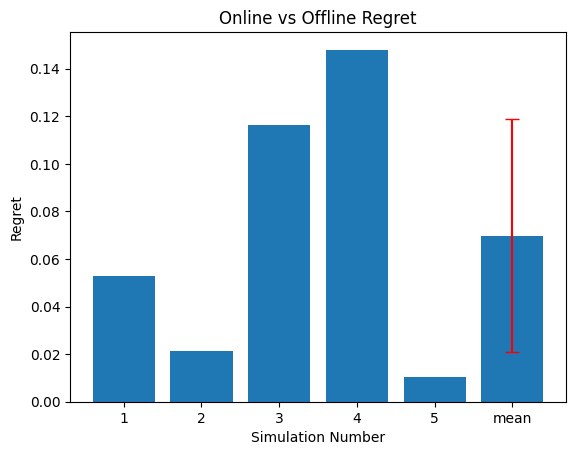

In [40]:
fig,ax = plt.subplots(1)
ax.bar(range(6), regrets)
ax.set_xticks(range(6), ['1', '2', '3', '4', '5', 'mean'])
ax.errorbar(5, regrets[-1], err[-1],color = 'r', capsize = 5)
ax.set_xlabel('Simulation Number')
ax.set_ylabel('Regret')
ax.set_title('Online vs Offline Regret')

# Question 2:
Dataset used: Tic-Tac-Toe Endgame

URL: https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame


In [6]:
# Reading in the data
filepath = 'tic-tac-toe.data'
with open(filepath) as f:
    data = []
    map = {'positive': 1, 'negative': 0, 'o':0, 'x':1, 'b': 2}
    for line in f:
        curr_line = line.strip().split(',')
        curr_line = [map[x] for x in curr_line]
        data.append([float(x) for x in curr_line])

data = np.array(data)

x = data[:,:-1] # Features
y = data[:,-1] # Labels of the data
print(x.shape, y.shape)

(958, 9) (958,)


In [13]:
# Question 2:
def Question2(x, y, seed=2024):
    N,k = x.shape
    gen = np.random.default_rng(seed)

    shuffled_x = x.copy()
    shuffled_y = y.copy()
    gen.shuffle(shuffled_x)
    gen.shuffle(shuffled_y)

    train_x, test_x = shuffled_x[:N//5], shuffled_x[N//5:]
    train_y, test_y = shuffled_y[:N//5], shuffled_y[N//5:]

    # Passive Learning
    # model = make_pipeline(StandardScaler(), SVC(probability=True))
    model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=50,max_depth = 4))

    passive_acc_log = []
    passive_cross_val_log = []
    for i in tqdm(range(N//2-N//5)):
        # Cross Validation
        cv_acc = []
        r = train_x.shape[0]
        for i in range(5):
            if i == 4:
                cv_train_x = train_x[r//5*i:]
                cv_test_x = train_x[:r//5*i]
                cv_train_y = train_y[r//5*i:]
                cv_test_y = train_y[:r//5*i]
            else:
                cv_train_x = train_x[r//5*i:r//5*(i+1)]
                cv_test_x = np.concatenate((train_x[:r//5*i],train_x[r//5*(i+1):]), axis = 0)
                cv_train_y = train_y[r//5*i:r//5*(i+1)]
                cv_test_y = np.concatenate((train_y[:r//5*i],train_y[r//5*(i+1):]), axis = 0)            
            passive_model = model.fit(cv_train_x, cv_train_y)
            pred_y = passive_model.predict(cv_test_x)
            cv_acc.append(accuracy_score(cv_test_y, pred_y))

        passive_cross_val_log.append(np.mean(cv_acc))
        
        # Updating training and testing dataset.
        train_x = np.concatenate((train_x,test_x[0:1]), axis = 0)
        train_y = np.concatenate((train_y,test_y[0:1]), axis = 0)
        test_x = test_x[1:]
        test_y = test_y[1:]

        passive_model = model.fit(train_x, train_y)
        pred_y = passive_model.predict(test_x)
        passive_acc_log.append(accuracy_score(test_y, pred_y))

    train_x, test_x = shuffled_x[:N//5], shuffled_x[N//5:]
    train_y, test_y = shuffled_y[:N//5], shuffled_y[N//5:]

    # Active Learning
    # model = make_pipeline(StandardScaler(), SVC(probability=True))
    model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=50,max_depth = 4))

    active_acc_log = []
    active_cross_val_log = []
    for i in tqdm(range(N//2-N//5)):
        # Cross Validation
        cv_acc = []
        r = train_x.shape[0]
        for i in range(5): 
            if i == 4:
                cv_train_x = train_x[r//5*i:]
                cv_test_x = train_x[:r//5*i]
                cv_train_y = train_y[r//5*i:]
                cv_test_y = train_y[:r//5*i]
            else:
                cv_train_x = train_x[r//5*i:r//5*(i+1)]
                cv_test_x = np.concatenate((train_x[:r//5*i],train_x[r//5*(i+1):]), axis = 0)
                cv_train_y = train_y[r//5*i:r//5*(i+1)]
                cv_test_y = np.concatenate((train_y[:r//5*i],train_y[r//5*(i+1):]), axis = 0)            
            active_model = model.fit(cv_train_x, cv_train_y)
            pred_y = active_model.predict(cv_test_x)
            cv_acc.append(accuracy_score(cv_test_y, pred_y))

        active_cross_val_log.append(np.mean(cv_acc))
        # Uncertainty Sampling Part:
        active_model = model.fit(train_x, train_y)
        prob_y = active_model.predict_proba(test_x)
        entropy = prob_y*np.log2(prob_y+1e-20)
        entropy = -np.sum(entropy, axis = 1)
        max_entropy_idx = np.argmax(entropy)

        # Updating training and testing dataset
        mask = np.ones(test_x.shape[0], dtype=bool)
        mask[max_entropy_idx] = False
        train_x = np.concatenate((train_x, test_x[max_entropy_idx:max_entropy_idx+1]), axis = 0)
        train_y = np.concatenate((train_y, test_y[max_entropy_idx:max_entropy_idx+1]), axis = 0)
        test_x = test_x[mask,...]
        test_y = test_y[mask,...]

        active_model = model.fit(train_x, train_y)
        pred_y = active_model.predict(test_x)
        active_acc_log.append(accuracy_score(test_y, pred_y))
    
    return passive_cross_val_log, passive_acc_log, active_cross_val_log, active_acc_log
        


In [14]:
for i in range(5):
    a,b,c,d = Question2(x,y,i*2024)
    if i == 0:
        passive_cv_log = np.array(a)[np.newaxis, :]
        passive_log = np.array(b)[np.newaxis, :]
        active_cv_log = np.array(c)[np.newaxis, :]
        active_log = np.array(d)[np.newaxis, :]
    else:
        passive_cv_log = np.concatenate((passive_cv_log, np.array(a)[np.newaxis, :]), axis = 0)
        passive_log = np.concatenate((passive_log, np.array(b)[np.newaxis, :]), axis = 0)
        active_cv_log = np.concatenate((active_cv_log, np.array(c)[np.newaxis, :]), axis = 0)
        active_log = np.concatenate((active_log, np.array(d)[np.newaxis, :]), axis = 0)

100%|██████████| 288/288 [01:29<00:00,  3.22it/s]


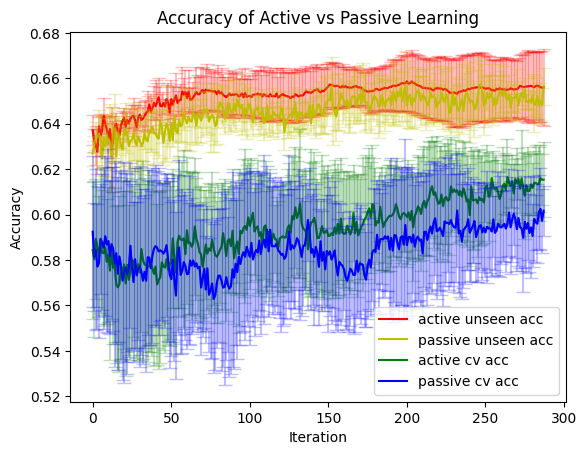

In [15]:
fig, ax = plt.subplots(1)
labels = ['active unseen acc', 'passive unseen acc', 'active cv acc', 'passive cv acc']
plot_datas = [active_log, passive_log, active_cv_log, passive_cv_log]
colors = ['r','y','g','b']
handles = []
for i in range(4):
    plot_data = plot_datas[i]
    plot_y = np.mean(plot_data, axis = 0)
    plot_x = np.arange(plot_y.shape[0])
    yerr = np.std(plot_data, axis = 0)
    handle, = ax.plot(plot_x,plot_y, label = labels[i], color = colors[i])
    ax.errorbar(plot_x,plot_y,yerr, alpha = 0.25, color = colors[i], capsize = 5)
    handles.append(handle)

ax.set_title('Accuracy of Active vs Passive Learning')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Iteration')
ax.legend(handles = handles)
plt.show(fig)

# Question 3:
Dataset used: Forest Fires

URL: https://archive.ics.uci.edu/dataset/162/forest+fires


In [41]:
# Reading in the data
# filepath = 'forestfires.csv'
# with open(filepath) as f:
#     data = []
#     f.readline() # Skip the first line.
#     month_map = {'jan': 0,
#                 'feb': 1,
#                 'mar': 2,
#                 'apr': 3,
#                 'may': 4,
#                 'jun': 5,
#                 'jul': 6,
#                 'aug': 7,
#                 'sep': 8,
#                 'oct': 9,
#                 'nov': 10,
#                 'dec': 11}
#     day_map = {'sun': 0,
#                'mon': 1,
#                'tue': 2,
#                'wed': 3,
#                'thu': 4,
#                'fri': 5,
#                'sat': 6}
#     for line in f:
#         curr_line = line.strip().split(',')
#         curr_line[2] = month_map[curr_line[2]]
#         curr_line[3] = day_map[curr_line[3]]
#         curr_line = curr_line[:2] + curr_line[4:]
#         data.append([float(x) for x in curr_line])

filepath = 'Daily_Demand_Forecasting_Orders.csv'
with open(filepath) as f:
    data = []
    f.readline() # Skip the first line.
    for line in f:
        curr_line = line.strip().split(';')
        data.append([float(x) for x in curr_line])


data = np.array(data)

x = data[:,:-1] # Features
y = data[:,-1] # Labels of the data
print(x.shape, y.shape)

(60, 12) (60,)


In [42]:
# Question 3:
def Question3(x, y, seed=2024):
    N,k = x.shape
    gen = np.random.default_rng(seed)

    shuffled_x = x.copy()
    shuffled_y = y.copy()
    gen.shuffle(shuffled_x)
    gen.shuffle(shuffled_y)

    train_x, test_x = shuffled_x[:N//5], shuffled_x[N//5:]
    train_y, test_y = shuffled_y[:N//5], shuffled_y[N//5:]

    # Passive Learning
    # model = make_pipeline(StandardScaler(), RandomForestRegressor())
    model = make_pipeline(StandardScaler(), LinearRegression())
   
    passive_err_log = []
    passive_cross_val_log = []
    for i in tqdm(range(N//2-N//5)):
        cv_err = []
        r = train_x.shape[0]
        for i in range(5):
            if i == 4:
                cv_train_x = train_x[r//5*i:]
                cv_test_x = train_x[:r//5*i]
                cv_train_y = train_y[r//5*i:]
                cv_test_y = train_y[:r//5*i]
            else:
                cv_train_x = train_x[r//5*i:r//5*(i+1)]
                cv_test_x = np.concatenate((train_x[:r//5*i],train_x[r//5*(i+1):]), axis = 0)
                cv_train_y = train_y[r//5*i:r//5*(i+1)]
                cv_test_y = np.concatenate((train_y[:r//5*i],train_y[r//5*(i+1):]), axis = 0)            
            passive_model = model.fit(cv_train_x, cv_train_y)
            pred_y = passive_model.predict(cv_test_x)
            cv_err.append(root_mean_squared_error(cv_test_y, pred_y))

        passive_cross_val_log.append(np.mean(cv_err))
        
        train_x = np.concatenate((train_x,test_x[0:1]), axis = 0)
        train_y = np.concatenate((train_y,test_y[0:1]), axis = 0)
        test_x = test_x[1:]
        test_y = test_y[1:]

        passive_model = model.fit(train_x, train_y)
        pred_y = passive_model.predict(test_x)
        passive_err_log.append(root_mean_squared_error(test_y, pred_y))


    train_x, test_x = shuffled_x[:N//5], shuffled_x[N//5:]
    train_y, test_y = shuffled_y[:N//5], shuffled_y[N//5:]

    # Active Learning
    # model = make_pipeline(StandardScaler(), RandomForestRegressor())
    model = make_pipeline(StandardScaler(), LinearRegression())

    active_err_log = []
    active_cross_val_log = []
    for i in tqdm(range(N//2-N//5)):
        cv_err = []
        r = train_x.shape[0]
        for i in range(5):
            if i == 4:
                cv_train_x = train_x[r//5*i:]
                cv_test_x = train_x[:r//5*i]
                cv_train_y = train_y[r//5*i:]
                cv_test_y = train_y[:r//5*i]
            else:
                cv_train_x = train_x[r//5*i:r//5*(i+1)]
                cv_test_x = np.concatenate((train_x[:r//5*i],train_x[r//5*(i+1):]), axis = 0)
                cv_train_y = train_y[r//5*i:r//5*(i+1)]
                cv_test_y = np.concatenate((train_y[:r//5*i],train_y[r//5*(i+1):]), axis = 0)            
            active_model = model.fit(cv_train_x, cv_train_y)
            pred_y = active_model.predict(cv_test_x)
            cv_err.append(root_mean_squared_error(cv_test_y, pred_y))

        active_model = model.fit(train_x, train_y)
        active_cross_val_log.append(np.mean(cv_err))
        # Uncertainty Sampling Part:
        pred_y = active_model.predict(test_x)
        sigma_squared = np.sum(np.power((test_y - pred_y),2))/(test_y.shape[0]-2)
        cov_mat = train_x.T@train_x
        var = sigma_squared*np.sum((test_x@cov_mat)*test_x, axis = 1)
        max_var_idx = np.argmax(var)

        mask = np.ones(test_x.shape[0], dtype=bool)
        mask[max_var_idx] = False
        train_x = np.concatenate((train_x, test_x[max_var_idx:max_var_idx+1]), axis = 0)
        train_y = np.concatenate((train_y, test_y[max_var_idx:max_var_idx+1]), axis = 0)
        test_x = test_x[mask,...]
        test_y = test_y[mask,...]

        active_model = model.fit(train_x, train_y)
        pred_y = active_model.predict(test_x)
        active_err_log.append(root_mean_squared_error(test_y, pred_y))

    
    return passive_cross_val_log, passive_err_log, active_cross_val_log, active_err_log
        


100%|██████████| 18/18 [00:00<00:00, 135.31it/s]


(18,) (18,) (18,)
(18,) (18,) (18,)
(18,) (18,) (18,)
(18,) (18,) (18,)


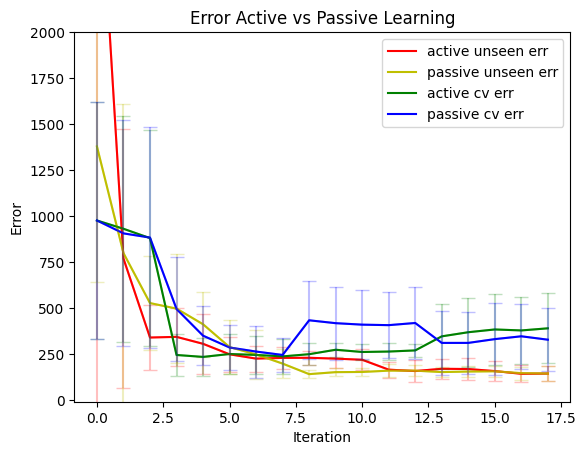

In [44]:
for i in range(5):
    a,b,c,d = Question3(x,y,i*2024)
    if i == 0:
        passive_cv_log = np.array(a)[np.newaxis, :]
        passive_log = np.array(b)[np.newaxis, :]
        active_cv_log = np.array(c)[np.newaxis, :]
        active_log = np.array(d)[np.newaxis, :]
    else:
        passive_cv_log = np.concatenate((passive_cv_log, np.array(a)[np.newaxis, :]), axis = 0)
        passive_log = np.concatenate((passive_log, np.array(b)[np.newaxis, :]), axis = 0)
        active_cv_log = np.concatenate((active_cv_log, np.array(c)[np.newaxis, :]), axis = 0)
        active_log = np.concatenate((active_log, np.array(d)[np.newaxis, :]), axis = 0)

# print(passive_cross_val_log.shape)
# raise Exception()
fig, ax = plt.subplots(1)
labels = ['active unseen err', 'passive unseen err', 'active cv err', 'passive cv err']
plot_datas = [active_log, passive_log, active_cv_log, passive_cv_log]
colors = ['r','y','g','b']
handles = []
for i in range(4):
    plot_data = plot_datas[i]
    plot_y = np.mean(plot_data, axis = 0)
    plot_x = np.arange(plot_y.shape[0])
    yerr = np.std(plot_data, axis = 0)
    print(plot_y.shape, plot_x.shape, yerr.shape)
    handle, = ax.plot(plot_x,plot_y, label = labels[i], color = colors[i])
    ax.errorbar(plot_x,plot_y,yerr, alpha = 0.25, color = colors[i], capsize = 5)
    handles.append(handle)
    ax.set_ylim(-10,2e3)
ax.legend(handles = handles)
ax.set_ylabel('Error')
ax.set_xlabel('Iteration')
ax.set_title('Error Active vs Passive Learning')
plt.show(fig)